In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

print(torch.__version__)

1.0.1.post2


Data loader

In [2]:
class FashionMnistread(Dataset):
    def __init__(self, mode, transform):
        dataset = FashionMNIST(root='./data', download=True, train=mode)
        data = getattr(dataset, 'train_data' if mode else 'test_data')
        labels = getattr(dataset, 'train_labels' if mode else 'test_labels')
        self.transform = transform
        self.input_images = np.array(data).astype(np.float)
        self.input_labels = np.array(labels).astype(np.long)

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels

training settings

In [3]:
BATCH_SIZE = 50
LR = 0.005
NUM_CLASS = 10
IMAGE_SIZE = 28
CHANNEL = 1
Train_epoch = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_CLOTHING = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

load Dataset

In [4]:
My_transform = transforms.Compose([
    transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
])

Train_data = FashionMnistread(True, transform=My_transform)
Test_data = FashionMnistread(False, transform=My_transform)

Train_dataloader = DataLoader(dataset=Train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )
Test_dataloader = DataLoader(dataset=Test_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )

/home/dspserver/ShareFolder/env/lib/python3.5/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dspserver/ShareFolder/env/lib/python3.5/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dspserver/ShareFolder/env/lib/python3.5/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/dspserver/ShareFolder/env/lib/python3.5/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


visualize trainning set

torch.Size([50, 1, 28, 28])


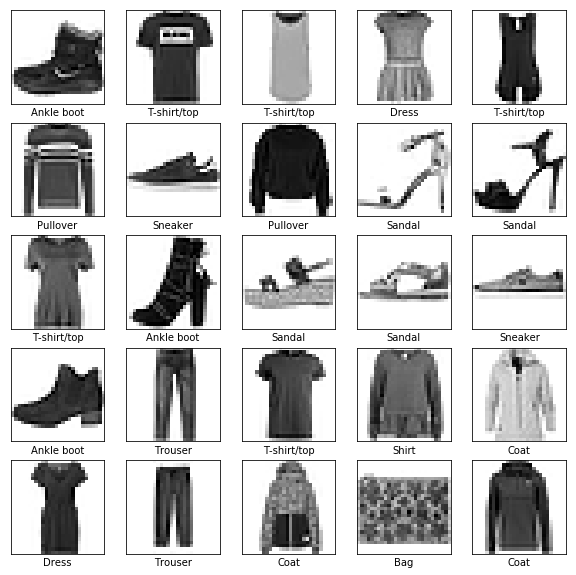

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images, train_labels = next(iter(Train_dataloader))
print(train_images.size())
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Build model

In [6]:
class My_Model(nn.Module):
    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim=1)
        return out

Initialize model

In [7]:
from torchsummary import summary
_model = My_Model(num_of_class = 10)
_model.to(device)
summary(_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          12,832
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                   [-1, 10]          15,690
Total params: 29,034
Trainable params: 29,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 0.11
Estimated Total Size (MB): 0.58
---------------------------------------------

training

In [8]:
from tqdm import tqdm_notebook

optimizer = torch.optim.Adam(_model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
for epoch in range(1, Train_epoch + 1):
    for image, label in tqdm_notebook(Train_dataloader):
        image, label = image.to(device), label.to(device)
        image = image.float() 
        output = _model(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))


Loss :1.5991 Epoch[1/5]



Loss :1.5824 Epoch[2/5]



Loss :1.5780 Epoch[3/5]



Loss :1.5567 Epoch[4/5]



Loss :1.5796 Epoch[5/5]


testing

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for image, label in tqdm_notebook(Test_dataloader):
        image = image.to(device)
        image = image.float() 
        label = label.to(device)
        outputs = _model(image)
        predicted = torch.argmax(outputs,dim=1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 88.61 %


In [10]:
test_images, test_labels = next(iter(Test_dataloader))
with torch.no_grad():
    image = test_images.to(device)
    image = image.float()
    predictions = _model(image)
predictions = predictions.cpu().data.numpy()

In [11]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

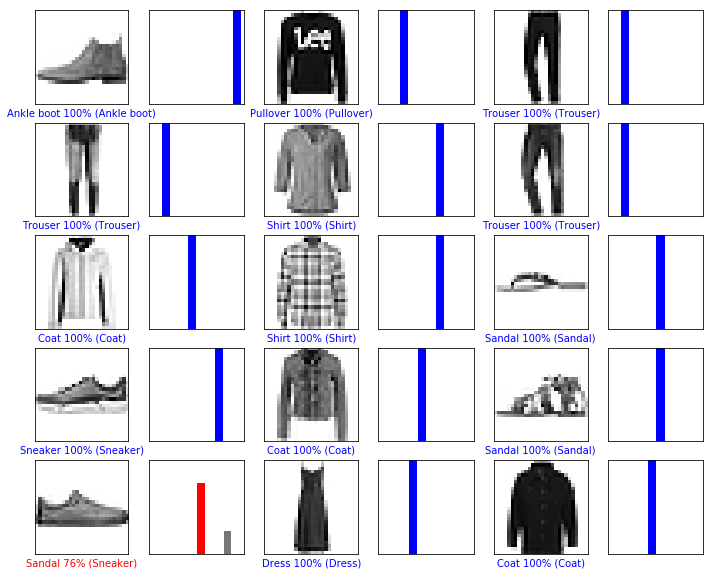

In [12]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.show()